In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
hats = pd.read_csv("data_gathering/csv_files/hat_all.csv", index_col=0)
guzergahs = pd.read_csv("data_gathering/csv_files/guzergah_all.csv", index_col=0)

In [3]:
hatkodu = hats[hats.HAT_DURUMU==1].HAT_KODU.to_numpy()

In [4]:
duraks = guzergahs[['DURAKKODU','XKOORDINATI','YKOORDINATI']].drop_duplicates()

In [5]:
# dk = gpd.GeoSeries.from_wkt(duraks.KOORDINAT)
dk = gpd.GeoSeries.from_xy(duraks.XKOORDINATI, duraks.YKOORDINATI)

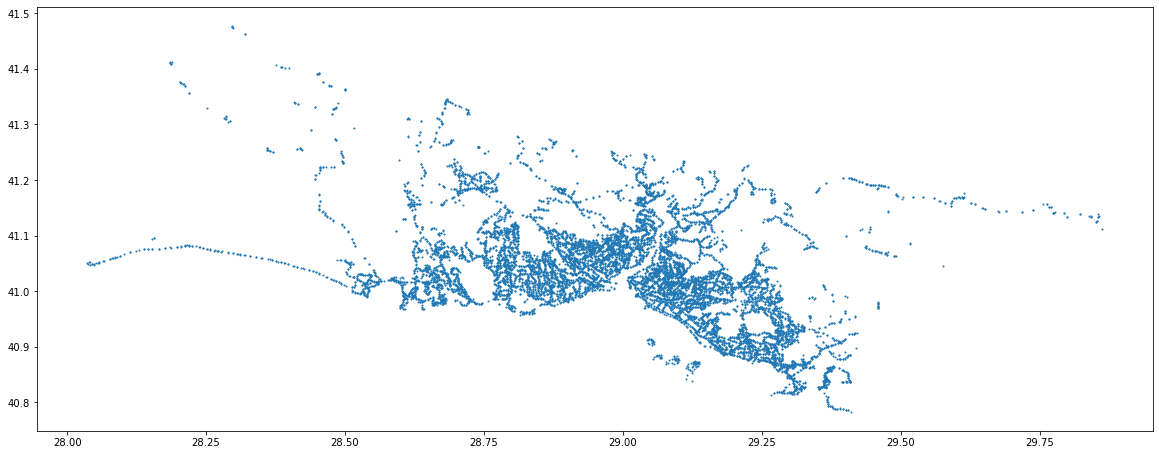

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
dk.plot(ax = ax, markersize=1)
plt.show()

In [7]:
G = nx.DiGraph()
G.add_nodes_from(duraks.DURAKKODU)
pos = {kod:(point.x, point.y) for kod, point in zip(duraks.DURAKKODU, dk)}

In [8]:
for hat in hatkodu:
    yol = guzergahs[(guzergahs.HATKODU==hat) & (guzergahs.YON=='D')]
    yol = list(zip(yol.SIRANO,yol.DURAKKODU))
    yol = sorted(yol)
    yol = [y[1] for y in yol]
    if len(yol)>1:
        yol = list(zip(yol[:-1], yol[1:]))
        G.add_edges_from(yol)
    
    yol = guzergahs[(guzergahs.HATKODU==hat) & (guzergahs.YON=='G')]
    yol = list(zip(yol.SIRANO,yol.DURAKKODU))
    yol = sorted(yol)
    yol = [y[1] for y in yol]
    if len(yol)>1:
        yol = list(zip(yol[:-1], yol[1:]))
        G.add_edges_from(yol)

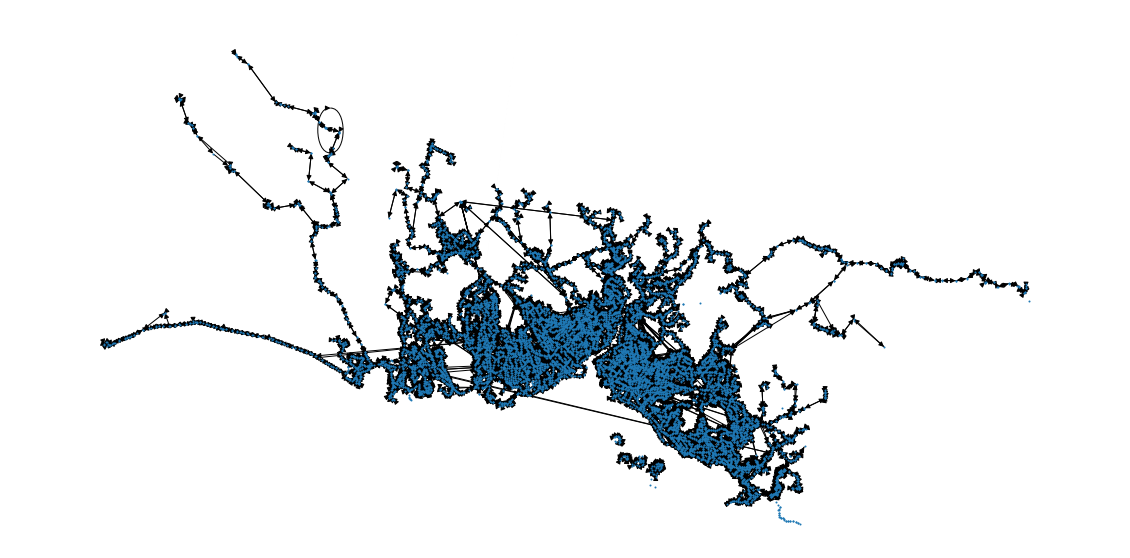

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
nx.draw(G, pos=pos, node_size=1, ax=ax)
plt.show()

In [24]:
# fig, ax = plt.subplots(1, 1, figsize=(15,15))
# ax.matshow(nx.linalg.graphmatrix.adjacency_matrix(G).todense())
# plt.show()